### Imports

In [ ]:
!pip install -r ../requirements.txt

In [2]:
import os
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import kaleido
import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

import networkx as nx

import warnings
warnings.filterwarnings("ignore")

In [3]:
def import_df(path):
    '''
    import dataframe from stage_2_2_model_pipline
    '''
    df_orig = pd.read_csv(path, sep='|', error_bad_lines=False)
    
    return df_orig

def import_subtopics_list(subtopics_path):
    '''
    import subtopics from stage_2_1_models/topic_model
    '''
    subtopics_file = open(subtopics_path, "r")
    subtopics = subtopics_file.read().split(",")
    subtopics_file.close()

    return subtopics

def import_subtopics_dict(d_topics_subtopics_path):
    '''
    import subtopics from stage_2_1_models/topic_model
    deprecated
    '''
    return 0

In [4]:
#path = '../stage_2_2_model_pipline/output/future_statements_sample.csv'
path = '../stage_2_2_model_pipline/output/future_statements.csv'

df_orig = import_df(path)

subtopics_path = '../stage_2_1_models/topic_model/subtopics.txt'

subtopics = import_subtopics_list(subtopics_path)

d_topics_subtopics_path = '../stage_2_1_models/topic_model/d_topics_subtopics.txt'

d_topics_subtopics_merged = import_subtopics_dict(d_topics_subtopics_path)

### Preprocessing

In [5]:
def major_lda_topic_to_topic(row, d_topics_subtopics):
    '''
    lda topic label to topic (deprecated)
    '''
    for i in range(0, len(d_topics_subtopics)):
        if row['major_lda_topic'] == i:
            return list(d_topics_subtopics.keys())[i]

def topic_to_subtopic_by_list(row, subtopics):
    '''
    get subtopic for each statement based on topic_eval subtopics-list
    '''
    for i in subtopics:
        if re.search(i, row['statement'], re.IGNORECASE):
            return i
    return 'undefined'

def topic_to_subtopic_by_dict(row, d_topics_subtopics):
    '''
    get subtopic for each statement based on topic_eval topics-subtopics-dict
    '''
    for ii in range(0, len(d_topics_subtopics)):
        if row['major_lda_topic'] == ii:
            for i in list(d_topics_subtopics.values())[ii]:
                if re.search(i, row['statement'], re.IGNORECASE):
                    return i
            return 'undefined'

def subtopic_to_network_by_list(row, subtopics):
    '''
    create network attribute for each statement based on topic_eval subtopics_list
    '''
    network = []
    for index, item in enumerate(subtopics):
        if (re.search(item, row['statement'], re.IGNORECASE)) and (item.casefold() not in network):
            network.append(item)
    return network

def subtopic_to_network_by_dict(row, d_topics_subtopics_merged):
    '''
    create network attribute for each statement based on topic_eval subtopics_list
    '''
    network = []
    for index, item in enumerate(d_topics_subtopics_merged):
        if (re.search(item, row['statement'], re.IGNORECASE)) and (item.casefold() not in network):
            network.append(item)
    return network

In [6]:
# d_topics_subtopics_merged = []
# for i in range(0,len(d_topics_subtopics)):
#     d_topics_subtopics_merged += list(d_topics_subtopics.values())[i]

In [7]:
#df_orig['topic'] = df_orig.apply(lambda row: major_lda_topic_to_topic(row, d_topics_subtopics), axis=1)
df_orig['subtopic'] = df_orig.apply(lambda row: topic_to_subtopic_by_list(row, subtopics), axis=1)
#df_orig['subtopic'] = df_orig.apply(lambda row: topic_to_subtopic_by_dict(row, d_topics_subtopics), axis=1)
df_orig['network'] = df_orig.apply(lambda row: subtopic_to_network_by_list(row, subtopics), axis=1)
#df_orig['network'] = df_orig.apply(lambda row: subtopic_to_network_by_dict(row, d_topics_subtopics_merged), axis=1)

In [8]:
def rchop(s, suffix):
    '''
    chop substring at the end of path
    '''
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

In [9]:
# export dataframe to .csv

#path = rchop(path, '.csv')
#path_for_vis = path + '_vis' + '.csv'
path_for_vis = 'output/future_statements' + '_vis' + '.csv'

df_orig.to_csv(path_for_vis, sep='|')
df = pd.read_csv(path_for_vis, sep='|', error_bad_lines=False)

### Sentiments

In [10]:
d_sentiment = {'NEG':-1,'NEU':0,'POS':1}

def sentiment_label(row):
    if row['sentiment'] == 'NEG':
        return -1
    elif row['sentiment'] == 'NEU':
        return 0
    elif row['sentiment'] == 'POS':
        return 1

In [11]:
df['n_sentiment'] = df.apply(lambda row:sentiment_label(row),axis=1)

### Visualization

In [12]:
dfg_t = {'count' : df.groupby(['topic']).size()}
dfg_t = pd.DataFrame(dfg_t).reset_index()

dfg_s = {'count' : df.groupby(['sentiment']).size()}
dfg_s = pd.DataFrame(dfg_s).reset_index()

dfg_ts = {'count' : df.groupby(['topic', 'n_sentiment']).size()}
dfg_ts = pd.DataFrame(dfg_ts).reset_index()

dfg_tm = df.groupby(['topic'])\
        .agg({'sentiment':'size', 'n_sentiment':'mean'}) \
        .rename(columns={'sentiment':'count', 'n_sentiment':'mean_sen'}).reset_index()

dfg_tsm = df.groupby(['topic', 'subtopic'])\
        .agg({'sentiment':'size', 'n_sentiment':'mean'}) \
        .rename(columns={'sentiment':'count', 'n_sentiment':'mean_sen'}).reset_index()

### Seaborn Init

In [13]:
mid_sen = 0
mean_sen = df['n_sentiment'].mean()

In [14]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,10)})

In [15]:
palette_1 = sns.color_palette("coolwarm_r", as_cmap=True)
palette_2 = sns.color_palette("coolwarm_r", 3)
colors_topics_pastel = sns.color_palette('pastel')[0:3]
palette_c = {}

### Seaborn Viz

#### Barplots

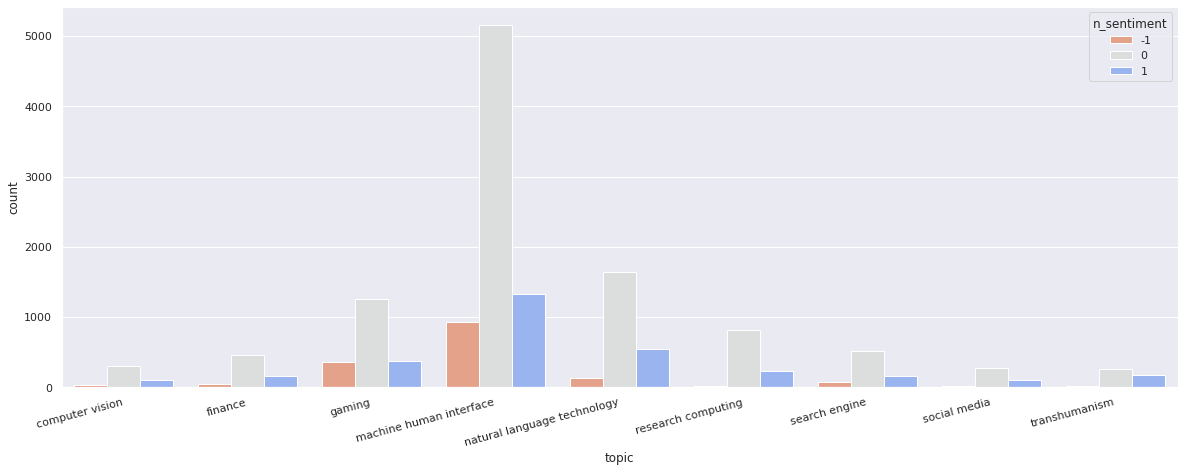

In [16]:
def barplots_topic(df, palette):
    '''
    create barplots for topics
    '''
    fig, ax = plt.subplots(figsize=(20, 7))

    # topic + sentiment (bar)
    sns.barplot(x = 'topic'
                , y = 'count'
                , data = dfg_ts
                , hue='n_sentiment'
                , palette= palette
                #, dodge=False
                , ax=ax
                )
    plt.xticks(rotation=15, ha="right")
    plt.savefig('plots/bar_topics.png')

barplots_topic(df=dfg_ts, palette=palette_2)

#### Pieplots

In [137]:
def pieplots_topic(pieplots_input, size):
    '''
    create pieplots for topics
    '''
    if not os.path.exists('plots'):
        os.mkdir('plots')
        
    #sunburst chart of topics+planned subtopics
    fig = px.sunburst(dfg_tsm
        ,path=['topic']
        ,values='count'
        ,branchvalues='total'
        ,title="Topics by Occurence"
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_topics_by_occ.png")

    #sunburst chart of topics+planned subtopics
    fig = px.sunburst(pieplots_input
        ,path=['subtopic']
        ,values='count'
        ,branchvalues='total'
        ,title="Subtopics by Occurence"
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_subtopics_by_occ.png")

    #sunburst chart of topics+planned subtopics
    fig = px.sunburst(pieplots_input
        ,path=['topic', 'subtopic']
        ,values='count'
        #,branchvalues='total'
        ,title="Topics & Subtopics by Occurence"
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_topics_subtopics_by_occ.png")

    fig = px.sunburst(pieplots_input #dfg_tsm[dfg_tsm['subtopic']!='undefined']
        ,path=['topic', 'subtopic']
        ,values='count'
        ,color='mean_sen'
        ,color_continuous_scale='RdBu'
        ,color_continuous_midpoint=mid_sen
        ,title="Topics & Subtopics (sentiment: NEUTRAL=0)"
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_topics_subtopics_by_occ_sent_neu.png")

    fig = px.sunburst(pieplots_input #dfg_tsm[dfg_tsm['subtopic']!='undefined']
        ,path=['topic', 'subtopic']
        ,values='count'
        ,color='mean_sen'
        ,color_continuous_scale='RdBu'
        ,color_continuous_midpoint=mean_sen
        ,title="Topics & Subtopics (sentiment: MEAN=%s)"%round(mean_sen,4)
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_topics_subtopics_by_occ_sent_mean.png")

    fig = px.sunburst(pd.DataFrame({'count' : df.groupby(['n_sentiment']).size()}).reset_index()
        ,path=['n_sentiment']
        ,values='count'
        ,color='n_sentiment'
        ,color_continuous_scale='RdBu'
        ,color_continuous_midpoint=0
        ,title="Sentiment by occurence"
        )
    fig.update_layout(
        autosize=False,
        width=size,
        height=size).show()
    fig.write_image("plots/pie_sent_by_occ.png")

In [138]:
pieplots_input = dfg_tsm
#pieplots_input = dfg_tsm[dfg_tsm['subtopic']!='undefined']
#pieplots_input = dfg_tsm[dfg_tsm['count']>=dfg_tsm['count'].mean()]

#topic_tops = dfg_tsm.groupby(['topic']).apply(lambda x: x.sort_values(['count'], ascending = False)).reset_index(drop=True)
topic_tops = dfg_tsm[dfg_tsm['subtopic']!='undefined'].groupby(['topic']).apply(lambda x: x.sort_values(['count'], ascending = False)).reset_index(drop=True)
pieplots_input = topic_tops.groupby('topic').head(5)


size = 600

pieplots_topic(pieplots_input, size)

### Network Graph

In [20]:
df['network'] = df['network'].apply(eval)

In [139]:
def create_graph(df):

    G = nx.Graph()

    node_sizes = {} #mglw als dict und dann key: nodename, value: frequence
    node_value = {}
    #after method: node_sizes and node_value into lists of the values

    for index, row in df.iterrows():
        if len(row['network']) > 1:
            for i_n in range(0, len(row['network'])):
                if row['network'][i_n].strip() not in G:
                    G.add_node(row['network'][i_n].strip(), freq=1)
                else:
                    for i_f in list(G.nodes.data("freq")):
                        if i_f[0] == row['network'][i_n].strip():
                            if i_f[1]:
                                name = i_f[0]
                                _freq = i_f[1]+1
                                G.remove_node(i_f[0])
                                G.add_node(row['network'][i_n].strip(), freq=_freq)
            for i_e in range(0, len(row['network'])-1):
                for ii_e in range(i_e+1, len(row['network'])):
                    if not G.has_edge(row['network'][i_e].strip(), row['network'][ii_e].strip()):
                        G.add_edge(row['network'][i_e].strip(), row['network'][ii_e].strip(), weight=1)
                    # else:
                    #     G[row['network'][i_e]][row['network'][ii_e]]['weight'] = G[row['network'][i_e]][row['network'][ii_e]]['weight'] + 1
    pos = nx.spring_layout(G, k=0.35, iterations=20) # positions for all nodes

    return G, pos, node_sizes, node_value

In [163]:
df[df['n_sentiment']==-1].head(7)

,Unnamed: 0,statement,sentiment,topic,url,subtopic,network,n_sentiment
22,22,A Pebblesorting AI would destroy the pebblesor...,NEG,machine human interface,http://lesswrong.com/lw/sy/sorting_pebbles_int...,undefined,[],-1
37,37,A bayesian superintelligence is not logically ...,NEG,machine human interface,http://lesswrong.com/lw/2jd/open_thread_august...,undefined,[],-1
39,39,A big AI settlement will have most of that and...,NEG,machine human interface,http://w-shadow.com/blog/2009/11/20/game-revie...,undefined,[],-1
52,52,A civil war - Doesn't happen Moving the capita...,NEG,machine human interface,http://forum.paradoxplaza.com/forum/showthread...,year,"[ year, reason]",-1
70,70,A context sensitive AI would only create more ...,NEG,machine human interface,http://thereticule.com/2009/06/arma-ii-the-ver...,undefined,[],-1
83,83,A faster group of units would be more dangerou...,NEG,machine human interface,http://www.gamedev.net/reference/articles/arti...,time,"[ time, area, unit]",-1
85,85,"A few (2-3) shots kills you, using cover is im...",NEG,machine human interface,http://gametoast.com/forums/viewtopic.php?f=72...,undefined,[],-1


In [179]:
def create_graph(df):

    G = nx.Graph()

    node_sizes = {} #mglw als dict und dann key: nodename, value: frequence
    node_value = {}
    #after method: node_sizes and node_value into lists of the values

    for index, row in df.iterrows():
        if len(row['network']) > 1:
            for i_n in range(0, len(row['network'])):
                if row['network'][i_n].strip() not in G:
                    G.add_node(row['network'][i_n].strip(), freq=1)
                    #node_value[row['network'][i_n].strip()].append(df['n_sentiment'][i_n])
                    node_value.update({row['network'][i_n].strip():row['n_sentiment']})
                    #node_sizes[row['network'][i_n].strip()].append(1)
                    node_sizes.update({row['network'][i_n].strip():1})
                else:
                    node_value[row['network'][i_n].strip()] = ((node_value[row['network'][i_n].strip()]*node_sizes[row['network'][i_n].strip()])+row['n_sentiment'])/(node_sizes[row['network'][i_n].strip()]+1)
                    node_sizes[row['network'][i_n].strip()] = node_sizes[row['network'][i_n].strip()] + 1
            for i_e in range(0, len(row['network'])-1):
                for ii_e in range(i_e+1, len(row['network'])):
                    if not G.has_edge(row['network'][i_e].strip(), row['network'][ii_e].strip()):
                        G.add_edge(row['network'][i_e].strip(), row['network'][ii_e].strip(), weight=1)
                    # else:
                    #     G[row['network'][i_e]][row['network'][ii_e]]['weight'] = G[row['network'][i_e]][row['network'][ii_e]]['weight'] + 1
    pos = nx.spring_layout(G, k=0.3, iterations=20) # positions for all nodes

    return G, pos, node_sizes, node_value

In [180]:
G, pos, node_sizes, node_value = create_graph(df)

In [181]:
a = list(node_value.values())

In [183]:
l_nodes = [item[0] for item in list(G.nodes.data("freq"))]
l_nodes_freq = [item[1] for item in list(G.nodes.data("freq"))]

In [112]:
# nx.draw(G
#     , pos
#     , node_size=[item[1]*100 for item in list(G.nodes.data("freq"))]
#     )

# nx.draw_random(G
#             , node_size=[item[1] for item in list(G.nodes.data("freq"))]
#             #, color='red'
#             )

In [ ]:
# nx.draw_spring(G
#             , node_size=[item[1] for item in list(G.nodes.data("freq"))]
#             #, color='red'
#             )

In [ ]:
# for i in list(G.nodes.data("freq")):
#     print(i[0], i[1])

#for edge in G.edges():
#    print(G.nodes[edge[0]]['freq'], '', edge)

In [257]:
#color_map = ['red' if node.size < 0 else 'blue' for node.size in G]

In [258]:
#nx.get_node_attributes(G,'freq')

{'recognition': Text(-0.1301077398977392, -0.2243954186024609, 'recognition'),
 'voice': Text(-0.38462459787902264, 0.026739563749304505, 'voice'),
 'technology': Text(-0.19408088524732073, -0.010521824316068587, 'technology'),
 'service': Text(0.09459864466632519, -0.5006397751744862, 'service'),
 'device': Text(-0.3948424866472378, 0.36567292201429275, 'device'),
 'start': Text(0.1336009275942527, -0.3716246005859816, 'start'),
 'company': Text(-0.4533614962601391, -0.5022274554544994, 'company'),
 'internet': Text(0.043024635924644394, -0.4583990424434788, 'internet'),
 'level': Text(-0.23113001842929667, -0.07235255702858424, 'level'),
 'data': Text(0.27733490915977377, 0.15183215230441463, 'data'),
 'mining': Text(-0.021430550699865086, -0.007489885717483662, 'mining'),
 'focus': Text(0.3076760573443331, -0.1459098317817064, 'focus'),
 'system': Text(0.06908390918918789, -0.20879530153264098, 'system'),
 'customer': Text(-0.13757698695832543, -0.5485068390560626, 'customer'),
 're

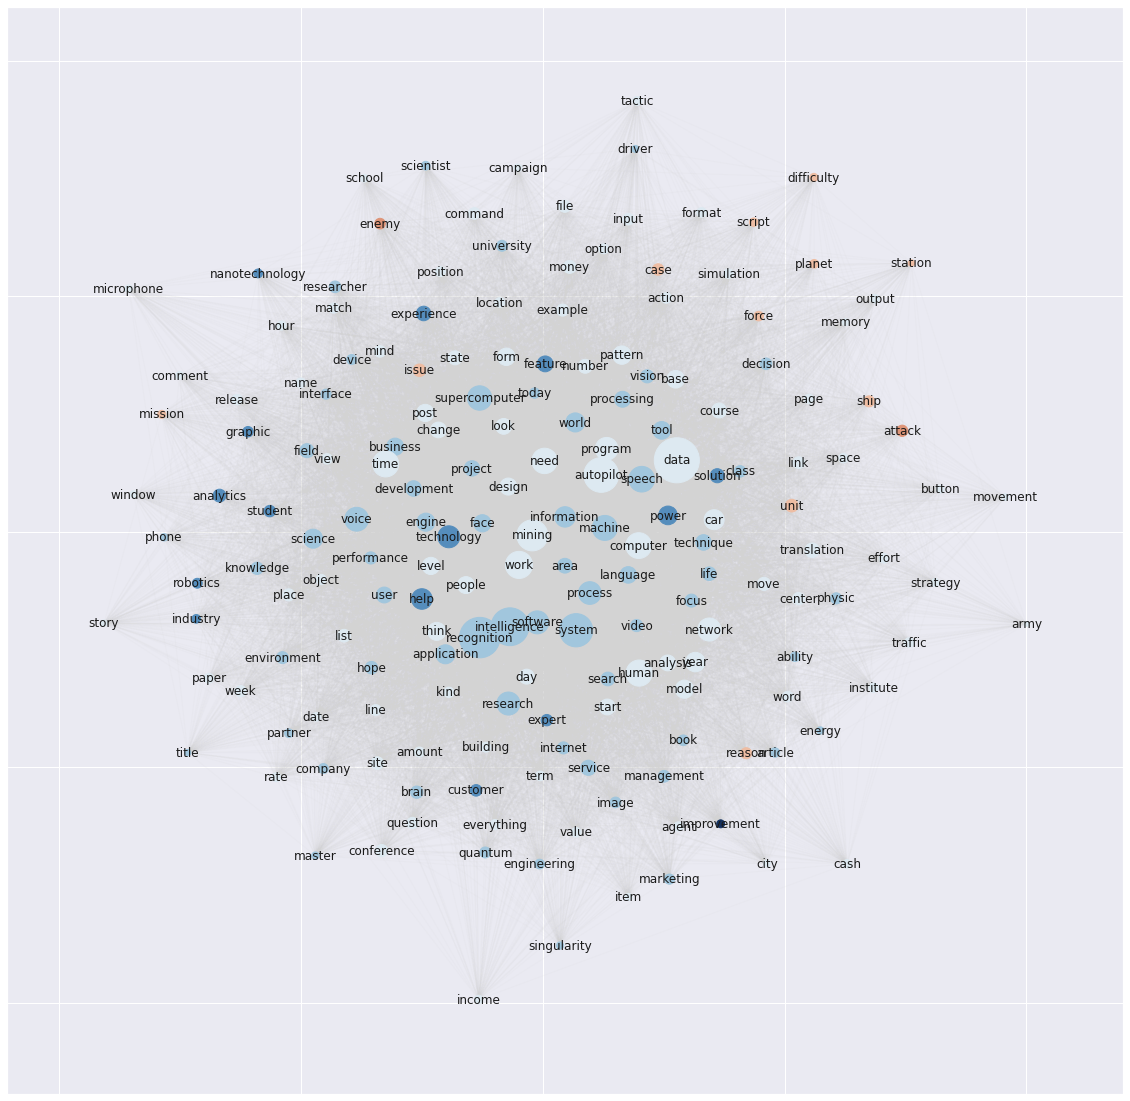

In [190]:
node_values_c = []
for i in list(node_value.values()):
    if i >= 0.8:
        node_values_c.append('#143160')
    elif i >= 0.6:
        node_values_c.append('#143160')
    elif i >= 0.4:
        node_values_c.append('#558DBC')
    elif i >= 0.2:
        node_values_c.append('#A1C6DD')
    elif i >= 0.0:
        node_values_c.append('#DDE9F1')
    elif i == 0.0:
        node_values_c.append('#FFFFFF')
    elif i >= -0.2:
        node_values_c.append('#EEBDA3')
    elif i >= -0.4:
        node_values_c.append('#DE9477')
    elif i >= -0.6:
        node_values_c.append('#C46150')
    elif i >= -0.8:
        node_values_c.append('#A42B32')
    elif i >= -1.0:
        node_values_c.append('#5F0E20')
    #elif i >= 0.8:

fig, ax = plt.subplots(figsize=(20, 20))

nx.draw_networkx_nodes(G,pos
                    , node_size=list(node_sizes.values()) #l_nodes_freq
                    , node_color=node_values_c
                    , alpha=1
                    )
nx.draw_networkx_edges(G,pos
                    #, edgelist = widths.keys()
                    #, width=list(widths.values())
                    , edge_color='lightgray'
                    , alpha=0.1
                    )
nx.draw_networkx_labels(G,pos
                        #,labels=dict(zip(nodelist,nodelist)),
                        #,font_color='white'
                        )